In [1]:
import os
import numpy as np

import torch

from sfno.utils import get_num_params,  get_seed
from sfno.pipeline import *
from sfno.losses import SobolevLoss
from sfno.datasets import BochnerDataset
from sfno.sfno import SFNO
from torch.utils.data import DataLoader

get_seed(42, printout=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
TRAIN_PATH = TEST_PATH = os.path.join(
    DATA_PATH, "McWilliams2d_fp32_64x64_N1152_v1e-3_T100.pt"
)

Ntrain = 1024
Ntest = 32

batch_size = 4

epochs = 5
learning_rate = 1e-2

n = 64
T = 10
fs = 'vorticity'

modes = 32
modes_t = 5
width = 10


model_name = f"sfno_v1e3_ep{epochs}_m{modes}_w{width}.pt"
path_model = os.path.join(MODEL_PATH, model_name)
print(model_name)

sfno_v1e3_ep5_m32_w10.pt


In [3]:
train_dataset = BochnerDataset(datapath=TRAIN_PATH, 
                               n_samples=Ntrain,
                               steps=T)
test_dataset = BochnerDataset(datapath=TEST_PATH, 
                              n_samples=Ntest,
                              steps=T,
                              train=False)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width).to(device)

print(get_num_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    div_factor=1e3,
    final_div_factor=1e3,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
)

l2diff = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)

16474521


In [6]:
for ep in range(epochs):
    model.train()
    train_l2 = 0

    with tqdm(total=len(train_loader), delay=1) as pbar:
        for i, data in enumerate(train_loader):
            l2 = train_batch_ns(
                model,
                l2diff,
                data,
                optimizer,
                device,
            )
            train_l2 += l2.item()
            is_epoch_scheduler = any(s in str(scheduler.__class__) for s in EPOCH_SCHEDULERS)
            if not is_epoch_scheduler:
                scheduler.step()

            if i % 4 == 0:
                pbar.set_description(f"train rel L2: {l2.item():.4e}")
                pbar.update(4)
    test_l2_min = 1e4
    test_l2 = eval_epoch_ns(
        model, l2diff, test_loader, device,
    )

    if test_l2 < test_l2_min:
        torch.save(model.state_dict(), path_model)
        test_l2_min = test_l2

    print(
        f"\nEpoch {ep+1} | ",
        f"Train L2: {train_l2/len(train_loader):.5e} |",
        f"Test  L2: {test_l2:.5e}\n",
    )

train rel L2: 2.3068e-01: 100%|██████████| 256/256 [00:07<00:00, 34.86it/s]



Epoch 1 |  Train L2: 2.60915e-01 | Test  L2: 2.22089e-01



train rel L2: 1.7737e-01: 100%|██████████| 256/256 [00:06<00:00, 38.52it/s]



Epoch 2 |  Train L2: 2.04787e-01 | Test  L2: 1.82281e-01



train rel L2: 1.3009e-01: 100%|██████████| 256/256 [00:06<00:00, 38.29it/s]



Epoch 3 |  Train L2: 1.51872e-01 | Test  L2: 1.28582e-01



train rel L2: 9.6893e-02: 100%|██████████| 256/256 [00:06<00:00, 38.55it/s]



Epoch 4 |  Train L2: 1.16344e-01 | Test  L2: 1.05533e-01



train rel L2: 9.2742e-02: 100%|██████████| 256/256 [00:06<00:00, 37.92it/s]



Epoch 5 |  Train L2: 1.00384e-01 | Test  L2: 9.85867e-02



In [17]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width).to(device)
model.load_state_dict(torch.load(path_model))
preds = []
gt_solns = []
test_l2_all = []

test_path = os.path.join(
    DATA_PATH, "McWilliams2d_fp64_256x256_N16_v1e-3_T100.pt"
)
test_dataset = BochnerDataset(datapath=test_path, 
                              n_samples=16,
                              steps=T,
                              train=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
n_test = 256
loss_func = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)

with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(test_loader):
        x, y = x[fs].to(device), y[fs].to(device)
        out = model(x)

        preds.append(out)
        gt_solns.append(y)

        test_l2 = loss_func(out, y).item()
        test_l2_all.append(test_l2)

preds = torch.cat(preds, dim=0)
gt_solns = torch.cat(gt_solns, dim=0)
print(np.mean(test_l2_all))

0.04338111216202378


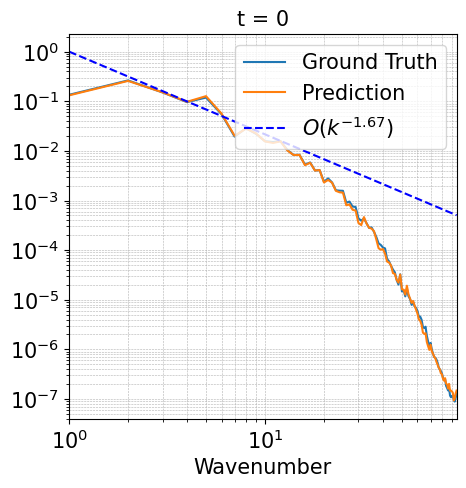

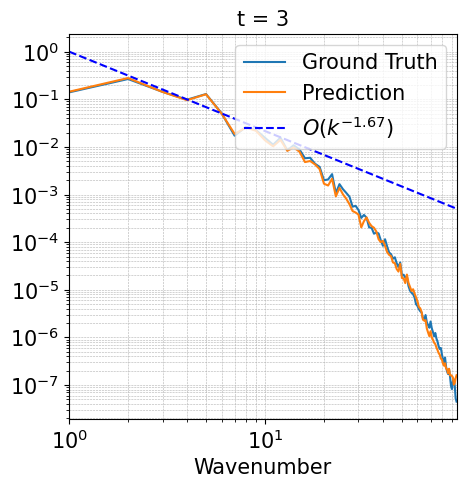

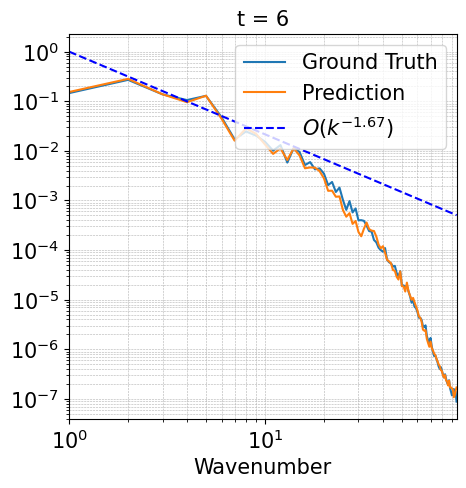

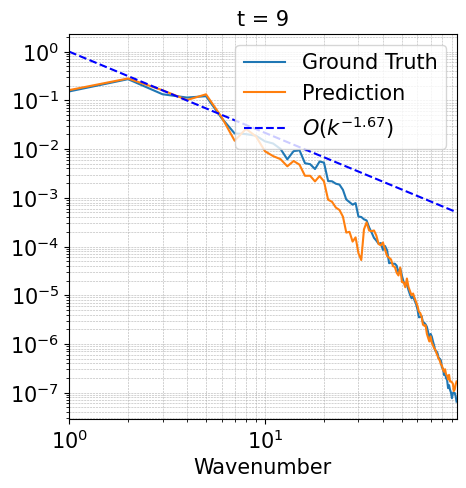

In [19]:
from sfno.visualizations import plot_enstrophy_spectrum
idx = np.random.randint(0, Ntest)

for t in range(0, T, 3):
    plot_enstrophy_spectrum(
        [gt_solns[idx, ..., t].cpu(),
        preds[idx, ..., t].cpu()],
        h=2 * np.pi / n_test,
        labels=["Ground Truth", "Prediction"],
        title=f"t = {t}",
        factor=1,
        slope=5/3
    )
